<a href="https://colab.research.google.com/github/ricpdc/QSPL-Survey/blob/main/QSE_Survey_Analysis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# QSE Hybrid Systems Survey — Reproducible Analysis (Colab)

**Project:** Validation of a Feature Model for Hybrid Quantum–Classical Systems (QSE)  
**Goal:** Load Google Sheets survey responses, clean data, produce tables/figures, and compute basic statistics (incl. reliability for Likert constructs), enabling a **re-runnable** pipeline as more responses arrive.

**Last updated:** 2025-10-02 06:32 UTC  
**Author(s):** _Add names here_

---

## How to use this notebook

1. Ensure the survey Google Sheet is shared appropriately (see **Config** cell).  
2. Run the notebook top-to-bottom.  
3. All figures and tables are written to `/content/outputs` in Colab (or the `outputs` folder if you mount Drive).  
4. The notebook is structured to be **self-contained and re-runnable**; you can refresh results as new responses arrive.


## 1. Runtime & libraries

In [1]:

#@title Install and import libraries
# If you need pinned versions, uncomment the pip cell and pin accordingly.
# %%capture
# !pip install pandas==2.2.2 numpy==2.0.2 matplotlib==3.9.0 scipy==1.13.1 statsmodels==0.14.2 gspread==6.1.4 gspread-dataframe==3.3.1

import os
import io
import sys
import json
import math
from pathlib import Path
from typing import List, Dict, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# (Optional) stats
import scipy.stats as stats
import statsmodels.api as sm

# (Optional) Google Sheets API
try:
    import gspread
    from gspread_dataframe import get_as_dataframe
    HAS_GSPREAD = True
except Exception as e:
    HAS_GSPREAD = False

print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('matplotlib:', plt.matplotlib.__version__)
print('scipy:', stats.__version__ if hasattr(stats, '__version__') else 'n/a')
print('statsmodels:', sm.__version__)
print('gspread available:', HAS_GSPREAD)


pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
scipy: n/a
statsmodels: 0.14.5
gspread available: True


## 2. Configuration (Google Sheets & paths)

In [2]:

#@title Configuration
from dataclasses import dataclass

# === Google Sheets ===
# Use the SHEET_ID from the spreadsheet URL:
# Example: https://docs.google.com/spreadsheets/d/<<SHEET_ID>>/edit?usp=sharing
SHEET_ID = "1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM"  # Provided by the project owner
# Optionally specify the GID for each sheet/tab if needed. The default (0) is often the first tab.
# You can find GID by opening the specific tab and reading the 'gid=<NUMBER>' param in the URL.
PRIMARY_GID = 0  # Change if your responses are in another tab

# === Access method ===
ACCESS_METHOD = "csv_export"  #@param ["csv_export", "gspread_oauth"]
# - "csv_export": uses public CSV export (Sheet must be at least 'Anyone with the link: Viewer')
# - "gspread_oauth": uses interactive OAuth in Colab (no need to make sheet public)

# === Paths ===
BASE_DIR = Path("/content")
OUTPUT_DIR = BASE_DIR / "outputs"
CACHE_DIR = BASE_DIR / "cache"
for d in (OUTPUT_DIR, CACHE_DIR):
    d.mkdir(parents=True, exist_ok=True)

# === Optional: Mount Google Drive ===
MOUNT_DRIVE = False  #@param {type:"boolean"}
if MOUNT_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    # Redirect outputs if desired:
    # OUTPUT_DIR = Path('/content/drive/MyDrive/qse_survey/outputs')
    # OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('OUTPUT_DIR:', OUTPUT_DIR)
print('CACHE_DIR:', CACHE_DIR)
print('ACCESS_METHOD:', ACCESS_METHOD)


OUTPUT_DIR: /content/outputs
CACHE_DIR: /content/cache
ACCESS_METHOD: csv_export


## 3. Data loading

In [3]:
#@title Helper functions to load Google Sheets (robust)
import urllib.error
import urllib.parse
import urllib.request
import pandas as pd

def sheets_csv_url(sheet_id: str, gid: int = 0) -> str:
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

def sheets_gviz_url_by_sheetname(sheet_id: str, sheet_name: str) -> str:
    # GVIZ endpoint supports selecting a tab by name
    # t q x = out:csv  (forces CSV)
    from urllib.parse import quote
    return f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={quote(sheet_name)}"

def try_read_csv(url: str) -> pd.DataFrame:
    # Give a clearer error if 400/403/404
    try:
        return pd.read_csv(url)
    except urllib.error.HTTPError as e:
        print(f"[ERROR] HTTPError {e.code} for URL: {url}")
        if e.code in (400, 403):
            print("This often means the sheet is not shared publicly OR the gid/sheet name is wrong.")
        raise
    except Exception as ex:
        print(f"[ERROR] Could not read CSV: {ex}")
        raise

def load_from_csv_export(sheet_id: str, gid: int = 0) -> pd.DataFrame:
    url = sheets_csv_url(sheet_id, gid)
    print("Attempting CSV export via gid:", gid)
    print("URL:", url)
    df = try_read_csv(url)
    return df

def load_from_gviz_by_sheetname(sheet_id: str, sheet_name: str) -> pd.DataFrame:
    url = sheets_gviz_url_by_sheetname(sheet_id, sheet_name)
    print("Attempting GVIZ CSV via sheet name:", sheet_name)
    print("URL:", url)
    df = try_read_csv(url)
    return df

def load_from_gspread(sheet_id: str, worksheet_index: int = 0) -> pd.DataFrame:
    assert HAS_GSPREAD, "gspread is not available. Install it and set ACCESS_METHOD='gspread_oauth'."
    print("Using gspread OAuth. You may be prompted to authorize.")
    gc = gspread.oauth()  # Will prompt in Colab the first time
    sh = gc.open_by_key(sheet_id)
    ws = sh.get_worksheet(worksheet_index)
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    # Clean all-null columns that may appear due to trailing columns
    if df.shape[1] > 0 and df.columns[-1] is None:
        df = df.iloc[:, :-1]
    return df

# Optional diagnostics: list worksheets if OAuth is available
def list_worksheets(sheet_id: str):
    if not HAS_GSPREAD:
        print("[INFO] gspread is not installed/available; cannot list worksheets.")
        return None
    try:
        gc = gspread.oauth()
        sh = gc.open_by_key(sheet_id)
        tabs = [ws.title for ws in sh.worksheets()]
        print("Worksheets:", tabs)
        return tabs
    except Exception as e:
        print("[WARN] Could not list worksheets via gspread:", e)
        return None

# ---- Main loading logic ----
# You can specify SHEET_NAME if you know the tab name (e.g., 'Form Responses 1').
SHEET_NAME = "data"  # o "Form Responses 1" según tu caso

df_raw = None
if ACCESS_METHOD == "csv_export":
    try:
        df_raw = load_from_csv_export(SHEET_ID, PRIMARY_GID)
    except Exception as e:
        print("\n[HINT] CSV export failed. Common causes:")
        print("- The spreadsheet (or that tab) is not shared as 'Anyone with the link: Viewer'.")
        print("- 'PRIMARY_GID' does not match the actual tab's gid.")
        print("- For private data, switch to ACCESS_METHOD='gspread_oauth'.")
        if SHEET_NAME:
            print("\nTrying GVIZ endpoint with SHEET_NAME...")
            df_raw = load_from_gviz_by_sheetname(SHEET_ID, SHEET_NAME)
        else:
            print("\nYou can set SHEET_NAME='Form Responses 1' (or your tab's name) and re-run to try GVIZ.")
            raise
elif ACCESS_METHOD == "gspread_oauth":
    df_raw = load_from_gspread(SHEET_ID, worksheet_index=0)
else:
    raise ValueError("ACCESS_METHOD must be one of: 'csv_export', 'gspread_oauth'")

print("Shape:", df_raw.shape)
df_raw.head(3)


Attempting CSV export via gid: 0
URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/export?format=csv&gid=0
[ERROR] HTTPError 400 for URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/export?format=csv&gid=0
This often means the sheet is not shared publicly OR the gid/sheet name is wrong.

[HINT] CSV export failed. Common causes:
- The spreadsheet (or that tab) is not shared as 'Anyone with the link: Viewer'.
- 'PRIMARY_GID' does not match the actual tab's gid.
- For private data, switch to ACCESS_METHOD='gspread_oauth'.

Trying GVIZ endpoint with SHEET_NAME...
Attempting GVIZ CSV via sheet name: data
URL: https://docs.google.com/spreadsheets/d/1t-3FYihK9DdpKpdtIgmWvYpduzWqeUkcL3p5npcCwDM/gviz/tq?tqx=out:csv&sheet=data
Shape: (23, 99)


,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
0,1/09/2025 8:55:10,No (but I’d like a brief explanation before co...,Yes,5.0,3.0,4.0,1.0,NaN,Partially,NaN,...,Intermediate (1-3 years),Beginner (0-1 years),Quantum Software Engineering,"Yes, I would like to be recognized.",Alexander,Weinert,Dr.,"German Aerospace Center (DLR), Institute of So...",Germany,alexander.weinert@dlr.de
1,3/09/2025 9:56:20,Yes,Yes,5.0,5.0,5.0,2.0,NaN,Yes,4.0,...,Advanced (3-5 years),Expert (7+ years),"Quantum Software Engineering, Hybrid Classical...","Yes, I would like to be recognized.",Mohammad Reza,Mousavi,Prof.,King's College London,NaN,NaN
2,4/09/2025 11:07:53,Yes,Partially,NaN,NaN,NaN,NaN,Quantum and classical parts of a hybrid optimi...,Partially,NaN,...,Advanced (3-5 years),Intermediate (1-3 years),"Quantum Software Engineering, Hybrid Classical...","No, let’s go to the end.",NaN,NaN,NaN,NaN,NaN,NaN


## 4. Data dictionary & pre-cleaning

In [4]:
# Convertir la lista de tuplas a un diccionario
DATA_DICTIONARY = dict([
    ("timestamp", "datetime"),
    ("SPL_familiar", "boolean"),
    ("gen_funct", "likert3"),
    ("f_funct_classical_functionality", "likert5"),
    ("f_funct_quantum_functionality", "likert5"),
    ("f_funct_gate_based", "likert5"),
    ("f_funct_adiabatic", "likert5"),
    ("alter_funct", "string"),
    ("gen_algo", "likert3"),
    ("f_algo_ftqc", "likert5"),
    ("f_algo_ftqc_deutsch_jozsa", "likert5"),
    ("f_algo_ftqc_bernstein_varizani", "likert5"),
    ("f_algo_ftqc_grover", "likert5"),
    ("f_algo_ftqc_simon", "likert5"),
    ("f_algo_ftqc_shor", "likert5"),
    ("f_algo_ftqc_qft", "likert5"),
    ("f_algo_ftqc_qpe", "likert5"),
    ("f_algo_ftqc_hhl", "likert5"),
    ("f_algo_nisq", "likert5"),
    ("f_algo_nisq_qaoa", "likert5"),
    ("f_algo_nisq_vqe", "likert5"),
    ("f_algo_nisq_qml", "likert5"),
    ("f_algo_hybrid", "likert5"),
    ("f_algo_hybrid_q_as_annealing", "likert5"),
    ("f_algo_hybrid_clustering", "likert5"),
    ("f_algo_hybrid_qaoa", "likert5"),
    ("f_algo_classical_algorithm", "likert5"),
    ("c_algo_1", "likert5"),
    ("alter_algo", "string"),
    ("gen_lang", "likert3"),
    ("f_lang_quantum_framework", "likert5"),
    ("f_lang_qiskit", "likert5"),
    ("f_lang_ocean_sdk", "likert5"),
    ("f_lang_cirq", "likert5"),
    ("f_lang_braket_sdk", "likert5"),
    ("f_lang_quantum_language", "likert5"),
    ("f_lang_qasm", "likert5"),
    ("f_lang_q_sharp", "likert5"),
    ("f_lang_classical_language", "likert5"),
    ("f_lang_python", "likert5"),
    ("f_lang_c_sharp", "likert5"),
    ("c_lang_1", "likert5"),
    ("c_lang_2", "likert5"),
    ("c_lang_3", "likert5"),
    ("c_lang_4", "likert5"),
    ("alter_lang", "string"),
    ("gen_hw", "likert3"),
    ("f_hw_error_correction", "likert5"),
    ("f_hw_active_error_correction", "likert5"),
    ("f_hw_surface_code", "likert5"),
    ("f_hw_bacon_shor_code", "likert5"),
    ("f_hw_ldpc_code", "likert5"),
    ("f_hw_error_mitigation", "likert5"),
    ("f_hw_zero_noise_extrapolation", "likert5"),
    ("f_hw_readout_mitigation", "likert5"),
    ("f_hw_probabilistic_error_cancellation", "likert5"),
    ("f_hw_native_gate_set", "likert5"),
    ("f_hw_single_qubit_gate", "likert5"),
    ("f_hw_two_qubits_gate", "likert5"),
    ("f_hw_pulse_control", "likert5"),
    ("alter_hw", "string"),
    ("gen_integ", "likert3"),
    ("f_integ_qcp_aa_s", "likert5"),
    ("f_integ_qf_aa_s", "likert5"),
    ("f_integ_orch_workflows", "likert5"),
    ("c_integ_1", "likert5"),
    ("alter_integ", "string"),
    ("ccc_funct_1", "likert3"),
    ("ccc_funct_2", "likert3"),
    ("ccc_algo_1", "likert3"),
    ("ccc_algo_2", "likert3"),
    ("ccc_algo_3", "likert3"),
    ("ccc_algo_4", "likert3"),
    ("ccc_lang_1", "likert3"),
    ("ccc_lang_2", "likert3"),
    ("ccc_lang_3", "likert3"),
    ("ccc_lang_4", "likert3"),
    ("ccc_lang_5", "likert3"),
    ("ccc_hw_1", "likert3"),
    ("ccc_hw_2", "likert3"),
    ("ccc_hw_3", "likert3"),
    ("ccc_integ_1", "likert3"),
    ("ccc_integ_2", "likert3"),
    ("ccc_integ_3", "likert3"),
    ("alter_ccc", "string"),
    ("alter_gen", "string"),
    ("phase", "category"),
    ("stars", "likert5"),
    ("role", "category"),
    ("exp_q", "category"),
    ("exp_spl", "category"),
    ("qc_areas", "category"),
    ("anon", "boolean"),
    ("first_name", "string"),
    ("last_name", "string"),
    ("title", "string"),
    ("affiliation", "string"),
    ("country", "category"),
    ("email", "string")
])

In [5]:

# Mapeo para los valores textuales de Likert (convertir en enteros)
LIKERT_5 = {
    "DK/NA": 0,
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
}

LIKERT_3 = {
    "DK/NA": 0,
    "No": 1,
    "Partially": 2,
    "Yes": 3,
}

# Función para mapear y limpiar las columnas
def canonicalize_columns(df: pd.DataFrame, dictionary: dict) -> pd.DataFrame:
    out = df.copy()
    for raw, typ in dictionary.items():
        if raw not in out.columns:
            print(f"[WARN] Missing expected column in sheet: {raw}")
            continue
        new = raw  # Usamos el nombre original de la columna
        out = out.rename(columns={raw: new})

        # Procesamiento de tipos
        if typ == "datetime":
            out[new] = pd.to_datetime(out[new], errors="coerce")
        elif typ == "numeric":
            out[new] = pd.to_numeric(out[new], errors="coerce")
        elif typ == "category":
            out[new] = out[new].astype("category")
        elif typ == "likert5":
            out[new] = out[new]
            # Solo reemplazamos NaN por 0, sin afectar los valores ya existentes (1, 2, 3, etc.)
            out[new] = pd.to_numeric(out[new], errors="coerce").fillna(0).astype("Int64")  # Usar 0 para NaNs
        elif typ == "likert3":
            # Solución para mapeo en likert3: reemplazar valores desconocidos por 0
            out[new] = out[new].apply(lambda x: LIKERT_3.get(x, 0)).astype("Int64")  # Usar 0 para valores no mapeados
        elif typ == "boolean":
            out[new] = out[new].apply(lambda x: True if str(x).strip().lower() == "yes" else False)
        elif typ == "string":
            out[new] = out[new].astype("str")

    return out

# Llamamos la función y mostramos los primeros registros
df = canonicalize_columns(df_raw, DATA_DICTIONARY)
print("Columns:", list(df.columns))
print("Rows:", len(df))
df.head(5)


Columns: ['timestamp', 'SPL_familiar', 'gen_funct', 'f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic', 'alter_funct', 'gen_algo', 'f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm', 'c_algo_1', 'alter_algo', 'gen_lang', 'f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp', 'c_lang_1', 'c_lang_2', 'c_lang_3', 'c_lang_4', 'alter_lang', 'gen_hw', 'f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code

,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
0,2025-01-09 08:55:10,False,3,5,3,4,1,nan,2,0,...,Intermediate (1-3 years),Beginner (0-1 years),Quantum Software Engineering,False,Alexander,Weinert,Dr.,"German Aerospace Center (DLR), Institute of So...",Germany,alexander.weinert@dlr.de
1,2025-03-09 09:56:20,True,3,5,5,5,2,nan,3,4,...,Advanced (3-5 years),Expert (7+ years),"Quantum Software Engineering, Hybrid Classical...",False,Mohammad Reza,Mousavi,Prof.,King's College London,NaN,nan
2,2025-04-09 11:07:53,True,2,0,0,0,0,Quantum and classical parts of a hybrid optimi...,2,0,...,Advanced (3-5 years),Intermediate (1-3 years),"Quantum Software Engineering, Hybrid Classical...",False,nan,nan,nan,nan,NaN,nan
3,2025-05-09 12:14:29,True,3,4,4,4,4,nan,3,5,...,Expert (7+ years),Advanced (3-5 years),"Quantum Software Engineering, Quantum Algorith...",False,Rui,Abreu,Prof.,University of Porto,Portugal,rui@computer.org
4,2025-08-09 20:13:43,False,3,5,5,2,2,nan,3,5,...,Intermediate (1-3 years),Beginner (0-1 years),"Quantum Software Engineering, Quantum Algorith...",False,nan,nan,nan,nan,NaN,nan


## 5. Exploratory Data Analysis (EDA)

In [6]:

#@title Overview and missingness
display(df.info())
display(df.describe(include='all'))
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 99 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   timestamp                              7 non-null      datetime64[ns]
 1   SPL_familiar                           23 non-null     bool          
 2   gen_funct                              23 non-null     Int64         
 3   f_funct_classical_functionality        23 non-null     Int64         
 4   f_funct_quantum_functionality          23 non-null     Int64         
 5   f_funct_gate_based                     23 non-null     Int64         
 6   f_funct_adiabatic                      23 non-null     Int64         
 7   alter_funct                            23 non-null     object        
 8   gen_algo                               23 non-null     Int64         
 9   f_algo_ftqc                            23 non-null     Int64       

None

,timestamp,SPL_familiar,gen_funct,f_funct_classical_functionality,f_funct_quantum_functionality,f_funct_gate_based,f_funct_adiabatic,alter_funct,gen_algo,f_algo_ftqc,...,exp_q,exp_spl,qc_areas,anon,first_name,last_name,title,affiliation,country,email
count,7,23,23.0,23.0,23.0,23.0,23.0,23,23.0,23.0,...,23,23,23,23,23,23,23,23,14,23
unique,NaN,2,<NA>,<NA>,<NA>,<NA>,<NA>,5,<NA>,<NA>,...,4,4,17,1,17,17,6,16,9,14
top,NaN,False,<NA>,<NA>,<NA>,<NA>,<NA>,nan,<NA>,<NA>,...,Intermediate (1-3 years),Beginner (0-1 years),"Quantum Software Engineering, Hybrid Classical...",False,nan,nan,nan,nan,Spain,nan
freq,NaN,13,<NA>,<NA>,<NA>,<NA>,<NA>,19,<NA>,<NA>,...,11,12,4,23,7,7,9,7,4,10
mean,2025-06-05 10:38:26.571428352,NaN,2.826087,4.26087,4.217391,4.130435,3.130435,NaN,2.565217,3.26087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2025-01-09 08:55:10,NaN,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2025-03-24 22:32:06.500000,NaN,3.0,4.0,4.0,4.0,2.5,NaN,2.0,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2025-05-09 12:14:29,NaN,3.0,5.0,5.0,5.0,3.0,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2025-08-25 05:20:59.500000,NaN,3.0,5.0,5.0,5.0,4.0,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2025-11-09 21:33:15,NaN,3.0,5.0,5.0,5.0,5.0,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0
timestamp,0.695652
country,0.391304
SPL_familiar,0.000000
f_funct_classical_functionality,0.000000
f_funct_quantum_functionality,0.000000
f_funct_gate_based,0.000000
f_funct_adiabatic,0.000000
alter_funct,0.000000
gen_algo,0.000000
f_algo_ftqc,0.000000


##Variable Grouping

In [7]:
from collections import OrderedDict

# Convert DATA_DICTIONARY to OrderedDict to preserve order
dict_ordered = OrderedDict(DATA_DICTIONARY)

# Flattened groups: each key -> list of Likert5 columns (features + constraints)
groups = OrderedDict()
current_group = None
current_columns = []

for col, typ in dict_ordered.items():
    if typ == "likert3" and col.startswith("gen_"):
        if current_group:
            groups[current_group] = current_columns
        current_group = col
        current_columns = []
    elif typ == "string" and col.startswith("alter_"):
        if current_group:
            groups[current_group] = current_columns
        current_group = None
        current_columns = []
    elif current_group and typ.startswith("likert5"):
        current_columns.append(col)

# Add last group if not already added
if current_group and current_columns:
    groups[current_group] = current_columns

# Display the flattened structure
for g, cols in groups.items():
    print(f"{g}: {cols}")

gen_funct: ['f_funct_classical_functionality', 'f_funct_quantum_functionality', 'f_funct_gate_based', 'f_funct_adiabatic']
gen_algo: ['f_algo_ftqc', 'f_algo_ftqc_deutsch_jozsa', 'f_algo_ftqc_bernstein_varizani', 'f_algo_ftqc_grover', 'f_algo_ftqc_simon', 'f_algo_ftqc_shor', 'f_algo_ftqc_qft', 'f_algo_ftqc_qpe', 'f_algo_ftqc_hhl', 'f_algo_nisq', 'f_algo_nisq_qaoa', 'f_algo_nisq_vqe', 'f_algo_nisq_qml', 'f_algo_hybrid', 'f_algo_hybrid_q_as_annealing', 'f_algo_hybrid_clustering', 'f_algo_hybrid_qaoa', 'f_algo_classical_algorithm', 'c_algo_1']
gen_lang: ['f_lang_quantum_framework', 'f_lang_qiskit', 'f_lang_ocean_sdk', 'f_lang_cirq', 'f_lang_braket_sdk', 'f_lang_quantum_language', 'f_lang_qasm', 'f_lang_q_sharp', 'f_lang_classical_language', 'f_lang_python', 'f_lang_c_sharp', 'c_lang_1', 'c_lang_2', 'c_lang_3', 'c_lang_4']
gen_hw: ['f_hw_error_correction', 'f_hw_active_error_correction', 'f_hw_surface_code', 'f_hw_bacon_shor_code', 'f_hw_ldpc_code', 'f_hw_error_mitigation', 'f_hw_zero_noise

##Histograms for likert3 variable groups

/tmp/ipython-input-32206552.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


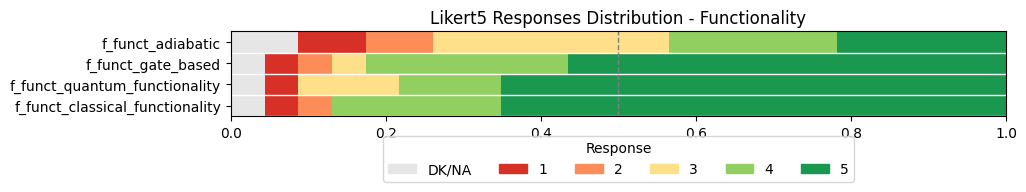

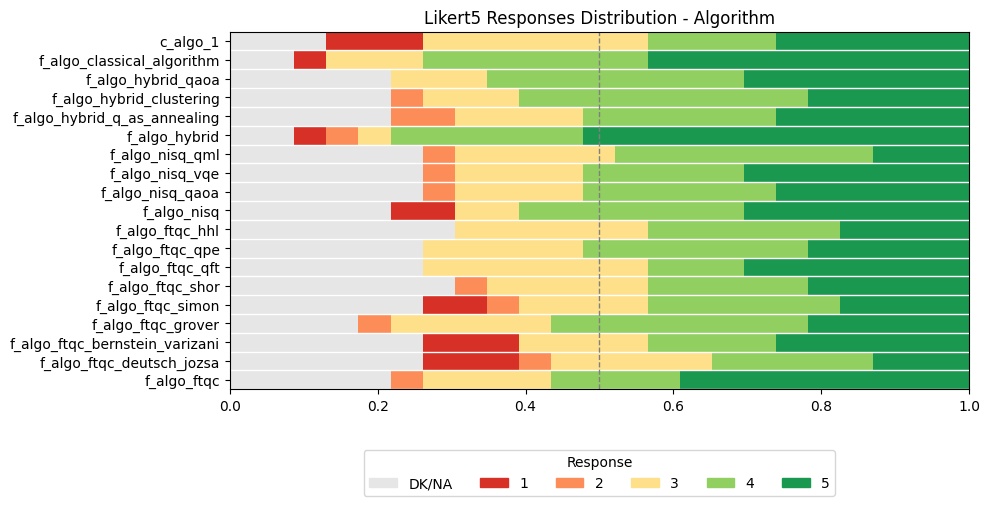

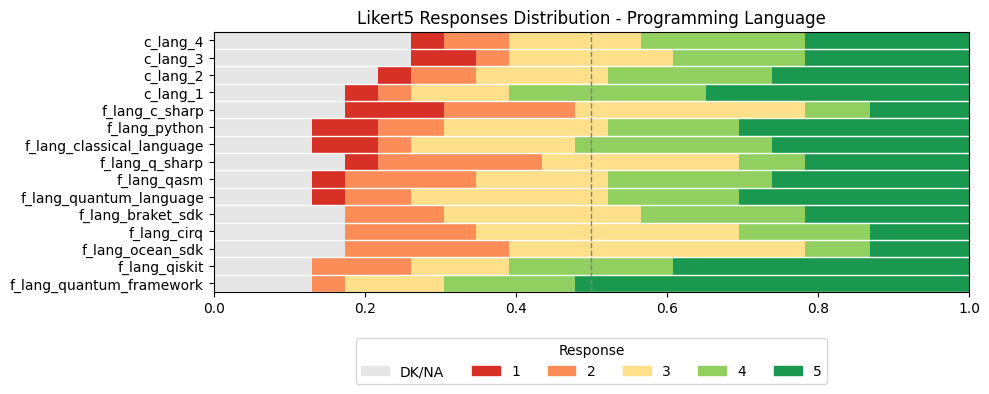

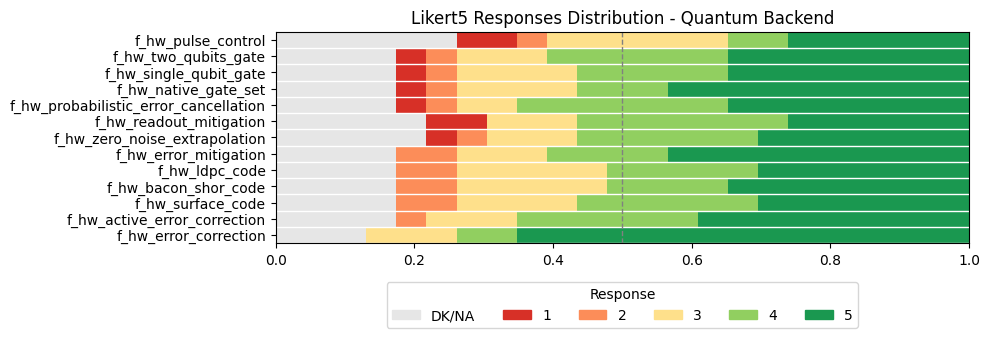

/tmp/ipython-input-32206552.py:94: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


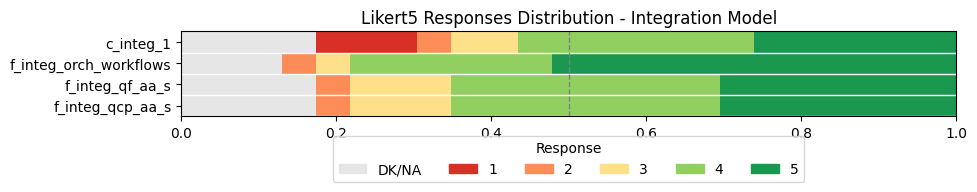

In [8]:
# Likert5 textual labels for legend
LIKERT_5_LABELS = ["DK/NA", "1", "2", "3", "4", "5"]

# Likert5 colors: DK/NA gray, 1 red → 5 green
LIKERT_5_COLORS = {
    0: "#e6e6e6",  # DK/NA gray
    1: "#d73027",  # red
    2: "#fc8d59",  # orange
    3: "#fee08b",  # amber
    4: "#91cf60",  # lime green
    5: "#1a9850",  # green
}

GEN_TITLE_MAP = {
    "gen_funct": "Functionality",
    "gen_algo": "Algorithm",
    "gen_lang": "Programming Language",
    "gen_hw": "Quantum Backend",
    "gen_integ": "Integration Model"
}

def plot_likert5_group_fixed_height(df, group_name, columns, bar_height_cm=0.6):
    """
    Plot 100% stacked horizontal bars for Likert5 variables,
    with fixed bar height (in cm) for all plots, no vertical gaps,
    and fully stacked.

    Parameters
    ----------
    df : pandas.DataFrame
        Processed DataFrame with numeric Likert5 columns
    group_name : str
        Name of the group
    columns : list
        List of Likert5 columns
    bar_height_cm : float
        Desired bar thickness in centimeters
    """
    if not columns:
        return

    df_group = df[columns]

    # Compute relative frequencies (percentages)
    df_percent = df_group.apply(lambda x: x.value_counts(normalize=True).sort_index()).fillna(0)
    df_percent = df_percent.T.iloc[::-1]  # reverse to have first variable at top

    n_vars = len(columns)

    # Convert bar height in cm to figure units
    dpi = 100  # figure dpi
    bar_height_inch = bar_height_cm / 2.54  # cm to inches
    fig_height = n_vars * bar_height_inch  # total figure height
    fig, ax = plt.subplots(figsize=(10, fig_height), dpi=dpi)

    # Plot stacked bars manually
    bottoms = np.zeros(n_vars)
    for val in sorted(df_percent.columns):
        ax.barh(
            y=np.arange(n_vars),
            width=df_percent[val],
            left=bottoms,
            color=LIKERT_5_COLORS.get(val, "#cccccc"),
            height=1.0
        )
        bottoms += df_percent[val].values

    # Add horizontal separator lines
    for y in range(n_vars):
        ax.hlines(y + 0.5, xmin=0, xmax=1, color='white', linestyle='-', linewidth=1)

    # Set limits and labels
    ax.set_ylim(-0.5, n_vars - 0.5)
    ax.set_xlim(0, 1)
    ax.set_yticks(np.arange(0, n_vars, 1))
    ax.set_yticklabels(df_percent.index)
    ax.invert_yaxis()  # first variable at top

    # ax.set_xlabel("Proportion")
    # ax.set_ylabel("Variables")

    # Map raw group_name to natural-language title if available
    plot_title = GEN_TITLE_MAP.get(group_name, group_name)
    ax.set_title(f"Likert5 Responses Distribution - {plot_title}")

    # Vertical reference line at 50%
    ax.axvline(0.5, color="gray", linestyle="--", linewidth=1)

    # Legend below plot, horizontal
    handles = [plt.Rectangle((0,0),1,1,color=LIKERT_5_COLORS[v]) for v in sorted(df_percent.columns)]
    ax.legend(handles, LIKERT_5_LABELS, title="Response", loc='upper center',
              bbox_to_anchor=(0.5, -0.15), ncol=len(LIKERT_5_LABELS))

    plt.tight_layout()
    plt.show()


for group_name, cols in groups.items():
    plot_likert5_group_fixed_height(df, group_name, cols, bar_height_cm=0.7)


In [9]:

#@title Histograms for numeric or Likert variables (edit COLS accordingly)
NUMERIC_COLS = ["first_do_you_consider_functionality_features_relevant_for_managing_variability_in_hybrid_software_development_i_e_should_this_sub_tree_of_features_be_included_in_the_variability_model"]  # e.g., ["years_qse", "fm_var_mgmt", "fm_algo_select"]
for col in NUMERIC_COLS:
    s = pd.to_numeric(df[col], errors='coerce')
    s = s.dropna()
    plt.figure()
    plt.hist(s, bins=10)
    plt.title("Distribution: {}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    out = OUTPUT_DIR / "hist_{}.png".format(col)
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)


KeyError: 'first_do_you_consider_functionality_features_relevant_for_managing_variability_in_hybrid_software_development_i_e_should_this_sub_tree_of_features_be_included_in_the_variability_model'

# Nueva sección

In [ ]:
#@title Frequency tables for categorical variables (edit COLS accordingly)
CATEGORICAL_COLS = ["phase", "role", "exp_q", "exp_spl", "qc_areas", "country"]  # e.g., ["role", "country", "framework_primary"]
freq_tables = {}
for col in CATEGORICAL_COLS:
    vc = df[col].value_counts(dropna=False)
    freq_tables[col] = vc
    print("\n=== {} ===".format(col))
    display(vc)

## 6. Reliability analysis (Cronbach's alpha)

In [ ]:

#@title Cronbach's alpha for constructs (set CONSTRUCTS accordingly)
def cronbach_alpha(df_subset: pd.DataFrame) -> float:
    # Standard Cronbach's alpha
    k = df_subset.shape[1]
    variances = df_subset.var(axis=0, ddof=1)
    total_var = df_subset.sum(axis=1).var(ddof=1)
    if total_var == 0 or k <= 1:
        return float('nan')
    return (k / (k - 1)) * (1 - variances.sum() / total_var)

# Define constructs as lists of column names with Likert (numeric) values
CONSTRUCTS = {
    # "Perceived usefulness of FM": ["fm_var_mgmt", "fm_algo_select", "fm_integration"],
    # "Perceived ease of use": ["ease_learning", "ease_modeling", "ease_tooling"],
}

alpha_results = {}
for name, cols in CONSTRUCTS.items():
    sub = df[cols].apply(pd.to_numeric, errors='coerce')
    sub = sub.dropna()
    a = cronbach_alpha(sub)
    alpha_results[name] = a
    if not (a != a):  # NaN check
        print(f"{name}: alpha = {a:.3f}")
    else:
        print(f"{name}: alpha = NA (insufficient variance or items)")

# Save alphas
pd.Series(alpha_results).to_csv(OUTPUT_DIR / "cronbach_alpha.csv")


## 7. Cross-tabs & basic significance tests

In [ ]:

#@title Chi-square tests for association (categorical x categorical)
PAIRS_CATEG = []  # e.g., [("role", "framework_primary")]
for a, b in PAIRS_CATEG:
    ct = pd.crosstab(df[a], df[b])
    chi2, p, dof, exp = stats.chi2_contingency(ct.fillna(0))
    print("\n{} vs {}".format(a, b))
    display(ct)
    print("chi2={:.3f}, dof={}, p={:.4f}".format(chi2, dof, p))


In [ ]:

#@title T-test / ANOVA for numeric outcomes (edit as needed)
# Example: Does perceived usefulness differ by role?
# OUTCOME = "fm_var_mgmt"
# GROUP = "role"
# dropna_rows = df[[OUTCOME, GROUP]].dropna()
# groups = [vals[OUTCOME].astype(float).values for _, vals in dropna_rows.groupby(GROUP)]
# if len(groups) > 1:
#     f, p = stats.f_oneway(*groups)
#     print("ANOVA: F={:.3f}, p={:.4f}".format(f, p))
# else:
#     print("Not enough groups for ANOVA")


## 8. Publication-ready tables & figures

In [ ]:

#@title Example: Likert stacked bar (5-point)
# Provide a helper to transform Likert columns to percentages per label
LIKERT_ORDER = [1, 2, 3, 4, 5]  # after mapping to numeric
LIKERT_LABELS = ["Strongly disagree","Disagree","Neutral","Agree","Strongly agree"]

def likert_table(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    # expects numeric 1..5
    table = []
    for c in cols:
        counts = df[c].value_counts().reindex(LIKERT_ORDER, fill_value=0)
        perc = (counts / counts.sum() * 100).round(1)
        row = perc.rename(c)
        table.append(row)
    out = pd.DataFrame(table, columns=LIKERT_ORDER)
    out.columns = LIKERT_LABELS
    return out

# Example usage:
LIKERT_COLS = []  # e.g., ["fm_var_mgmt", "fm_algo_select", "fm_integration"]
if LIKERT_COLS:
    tbl = likert_table(df, LIKERT_COLS)
    display(tbl)
    tbl.to_csv(OUTPUT_DIR / "likert_table.csv")


In [ ]:

#@title Plot: Likert stacked bars
def plot_likert_stacked(table: pd.DataFrame, title: str = "Perception of FM"):
    # table columns should be ordered as LIKERT_LABELS
    ax = table.plot(kind="bar", stacked=True, figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Item")
    plt.ylabel("Percentage")
    plt.legend(title="Response", bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    out = OUTPUT_DIR / ("likert_stacked_" + title.replace(" ", "_").lower() + ".png")
    plt.savefig(out, dpi=200)
    plt.show()
    print("Saved:", out)

# Example:
# if LIKERT_COLS:
#     tbl = likert_table(df, LIKERT_COLS)
#     plot_likert_stacked(tbl, title="Usefulness of the Feature Model")


## 9. Reproducibility

In [ ]:

#@title Save session info and a minimal requirements file
import platform, subprocess

session = {
    "python": sys.version,
    "platform": platform.platform(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "scipy": stats.__version__ if hasattr(stats, '__version__') else None,
    "statsmodels": sm.__version__,
    "gspread": HAS_GSPREAD,
}
with open(OUTPUT_DIR / "session_info.json", "w") as f:
    json.dump(session, f, indent=2)
print(json.dumps(session, indent=2))

# Minimal requirements (edit as needed)
req = """
pandas
numpy
matplotlib
scipy
statsmodels
gspread
gspread-dataframe
"""
with open(OUTPUT_DIR / "requirements.txt", "w") as f:
    f.write(req.strip() + "\n")
print("Wrote:", OUTPUT_DIR / "requirements.txt")



## Appendix: Paper-oriented narrative (to fill in)

### A. Research Questions (RQs)
- RQ1: *To what extent does the proposed Feature Model cover variability in functionalities, algorithms, frameworks and integration models for hybrid Q–C systems?*
- RQ2: *What is the perceived usefulness and ease of use of the Feature Model among QSE experts?*
- RQ3: *Which factors (e.g., role, experience, domain) explain differences in adoption intent?*

### B. Method
- Instrument: Google Forms survey (include sections and sample items).
- Participants: N=..., sampling & inclusion criteria.
- Measures: Likert items grouped in constructs; open-ended items.
- Analysis: Reliability (Cronbach’s alpha), descriptive stats, cross-tabs & significance tests.

### C. Results
- Response flow and demographics.
- Construct reliability and descriptive stats.
- Key figures: Likert stacked bars; histograms; cross-tabs.

### D. Discussion
- Alignment with prior QSE/SPL research; implications for Feature Models in hybrid Q–C systems.
- Threats to validity: construct, internal, external, conclusion validity.
- Limitations and future work.

### E. Reuse in the paper
Export figures from `/content/outputs` and reference them in the manuscript. Tables (CSV) can be loaded into LaTeX or Word tables.
